In [1]:
from mendeleev.fetch import fetch_table
from torch import nn as pnn
from torch.utils import data as pdat
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torch_geometric import nn as gnn
from torch_geometric import data as gdat
from torch_geometric.loader import DataLoader as GeoDataLoader
from monty.serialization import loadfn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, mean_absolute_error,
                             f1_score, accuracy_score, recall_score, precision_score)
import numpy as np
import json, torch

periodic_table = fetch_table('elements')
feats = ['atomic_number', 'atomic_radius', 'atomic_volume', 'group_id', 'period', 'en_pauling']
atom_feat_table = periodic_table[feats].values

# MP Data setting

## Property data (band gap)

In [19]:
from monty.serialization import loadfn

mp_prop_data = loadfn('../data/mp_Li_O_3ele_clean.monty')

In [20]:
index = np.arange(len(mp_prop_data))
train_index, test_index = train_test_split(index, test_size = 0.2, random_state=123)

train_data = np.array(mp_prop_data)[sorted(train_index)]
test_data = np.array(mp_prop_data)[sorted(test_index)]
len(train_data), len(test_data)

(1474, 369)

In [22]:
def strucutre_to_graph(structure, r=3):
    neighbors = structure.get_all_neighbors(r=r)
    pairs = []
    atoms = []
    edge_index = []
    edge_attr = []
    for i, nns in enumerate(neighbors):
        atoms.append(structure[i].specie.number - 1)
        for n in nns:
            pair = (i, n.index, f'{n.nn_distance:.8f}')
            if pair not in pairs:
                pairs.append(pair)
                edge_index.append(pair[:2])
                edge_attr.append(float(pair[2]))
    x = atom_feat_table[atoms]
    return {'x':x, 'edge_index':np.array(edge_index).T, 'edge_attr':np.array(edge_attr)}

### [Pytorch geometric (PyG)](https://pytorch-geometric.readthedocs.io/en/latest/index.html)

Graph 데이터를 효율적으로 다룰 수 있도록 돕는 pytorch library로, GNN에 특화된 pytorch 기능들을 제공함

특히 Graph data를 다루는데 있어, torch_geometric의 dataset, dataloader 등을 활용하면 복잡한 과정들을 생략할 수 있음

#### PyG를 활용한 dataset 생성

In [150]:
class GeoDataset(gdat.Dataset):
    def __init__(self, mp_dataset, target='band_gap', target_dtype=float, r=3):
        super(GeoDataset, self).__init__()
        self._data = []
        for mp_data in mp_dataset:
            data = strucutre_to_graph(mp_data['structure'], r=r)
            # torch_geometric.data 의 Data object를 이용해 하나의 데이터를 구성
            self._data.append(gdat.Data(
                x = torch.from_numpy(data['x']).float(), 
                edge_index = torch.from_numpy(data['edge_index']).long(), 
                edge_attr = torch.from_numpy(data['edge_attr']).float().view(-1,1),
                y = torch.from_numpy(np.array(mp_data[target], dtype=target_dtype)).view(1,-1)
            ))
    
    def __getitem__(self, i):
        # 개별 데이터는 torch_geometric.data 의 Data object를 그대로 반환
        if isinstance(i, (list, tuple)):
            return [self._data[_i] for _i in i]
        return self._data[i]

    def __len__(self):
        return len(self._data)

In [23]:
test_dataset_geo = GeoDataset(test_data)
test_dl_geo = GeoDataLoader(test_dataset_geo, batch_size=4)
batch_geo = next(iter(test_dl_geo))
print(batch_geo)
print('-'*80)
print(test_dataset_geo[0])
print(test_dataset_geo[1])
print(test_dataset_geo[2])
print(test_dataset_geo[3])

DataBatch(x=[92, 6], edge_index=[2, 834], edge_attr=[834, 1], y=[4, 1], batch=[92], ptr=[5])
--------------------------------------------------------------------------------
Data(x=[6, 6], edge_index=[2, 34], edge_attr=[34, 1], y=[1, 1])
Data(x=[7, 6], edge_index=[2, 62], edge_attr=[62, 1], y=[1, 1])
Data(x=[60, 6], edge_index=[2, 602], edge_attr=[602, 1], y=[1, 1])
Data(x=[19, 6], edge_index=[2, 136], edge_attr=[136, 1], y=[1, 1])


#### Pytorch의 module을 활용한 graph dataset 생성

In [21]:
class MyData:
    def __init__(self, x, edge_index=[[], []], edge_attr=None, y=None, id=None):
        self._x = x.float() if isinstance(x, torch.Tensor) else torch.tensor(x).float()
        self._edge_index = edge_index.long() if isinstance(edge_index, torch.Tensor) else torch.tensor(edge_index).long()
        
        self._edge_attr = edge_attr
        if edge_attr is not None:
            self._edge_attr = edge_attr.float() if isinstance(edge_attr, torch.Tensor) else torch.tensor(edge_attr).float()
            
        self._y = y
        if y is not None:
            # single label task를 가정했음. 일반적으로, label이 여러개라면 (num_data, num_label) 이 되어야 함
            self._y = y.view(-1,1) if isinstance(y, torch.Tensor) else torch.tensor(y).view(-1,1) 
        
        self._id = id
        n = self._x.shape[0]
        self._batch = torch.tensor([0] * n).long()
        self._ptr = torch.tensor([0, n]).long()
    
    @property
    def x(self):
        return self._x

    @x.setter
    def x(self, value):
        if self._x.shape != value.shape:
            raise ValueError('Invalid setting data', self._x.shape, value.shape)
        self._x = value

    @property
    def edge_index(self):
        return self._edge_index

    @property
    def edge_attr(self):
        return self._edge_attr

    @edge_attr.setter
    def edge_attr(self, value):
        if self._edge_attr.shape != value.shape:
            raise ValueError('Invalid setting data', self._edge_attr.shape, value.shape)
        self._edge_attr = value

    @property
    def y(self):
        return self._y

    @y.setter
    def y(self, value):
        if self._y.shape != value.shape:
            raise ValueError('Invalid setting data', self._y.shape, value.shape)
        self._y = value

    @property
    def id(self):
        return self._id
    
    @property
    def batch(self):
        return self._batch
    
    @property
    def ptr(self):
        return self._ptr

    @property
    def num_nodes(self):
        return self._x.shape[0]

    @property
    def num_node_features(self):
        return self._x.shape[1]

    @property
    def num_edges(self):
        return self._edge_attr.shape[0]

    @property
    def num_edge_features(self):
        return self._edge_attr.shape[1]
    
    def to(self, device):
        self._x = self._x.to(device)
        self._edge_index = self._edge_index.to(device)
        self._edge_attr = self._edge_attr.to(device)
        self._y = self._y.to(device)
        self._batch = self._batch.to(device)
        self._ptr = self._ptr.to(device)
        
class TorchDataset(pdat.Dataset):
    def __init__(self, mp_dataset, target='band_gap', task='reg', r=3):
        super(TorchDataset, self).__init__()
        self._data = []
        for mp_data in mp_dataset:
            graph = strucutre_to_graph(mp_data['structure'], r=r)
            n = graph['edge_index'].shape[1]
            y = np.array(mp_data[target])
            if task.startswith('c'):
                y = y.reshape(-1).astype(int)
            else:
                y = y.reshape(1,-1).astype(np.float32)

            self._data.append(MyData(
                x = graph['x'], 
                edge_index = graph['edge_index'], 
                edge_attr = graph['edge_attr'].reshape(n, -1),
                y = y,
                id = mp_data['material_id'],
            ))
    
    def __getitem__(self, i):
        try:
            return [self._data[_i] for _i in i]
        except:                
            return self._data[i]

    def __len__(self):
        return len(self._data)

    def to(self, device):
        for d in self._data:
            d.to(device)
        return self
        
def my_collate_fn(dataset):
    x = []
    edge_attr = []
    edge_index = []
    y = []
    batch = []
    ptr = [0]
    id = []
    n = 0
    for i, data in enumerate(dataset):
        x.append(data.x)
        if data.y is not None: 
            y.append(data.y)
        if data.edge_attr is not None: 
            edge_attr.append(data.edge_attr)
        
        edge_index.append(data.edge_index + n)
        batch.append(data.batch +i)
        n += data.num_nodes
        ptr.append(n)
        id.append(data.id)
        
    collated_data = MyData(
        x = torch.concat(x, dim=0),
        edge_attr = torch.concat(edge_attr, dim=0) if len(edge_attr) != 0 else None,
        edge_index = torch.concat(edge_index, dim=1),
        y = torch.concat(y, dim=0) if len(y) != 0 else None,
        id = id
    )
    collated_data._batch = torch.concat(batch, dim=0)
    collated_data._ptr = torch.tensor(ptr).long()
    return collated_data, collated_data.y

In [9]:
test_dataset_tch = TorchDataset(test_data)
test_dl_tch = pdat.DataLoader(test_dataset_tch, batch_size=4, collate_fn=my_collate_fn)
batch_tch = next(iter(test_dl_tch))

In [10]:
print('x shape')
print(batch_geo.x.shape, batch_tch.x.shape)
print('\nbatch')
print(batch_geo.batch[-10:])
print(batch_tch.batch[-10:])
print('\nedge_index')
print(batch_geo.edge_index.T[-10:].T)
print(batch_tch.edge_index.T[-10:].T)

x shape
torch.Size([92, 6]) torch.Size([92, 6])

batch
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

edge_index
tensor([[90, 90, 91, 91, 91, 91, 91, 91, 91, 91],
        [73, 83, 86, 90, 87, 80, 76, 82, 79, 83]])
tensor([[90, 90, 91, 91, 91, 91, 91, 91, 91, 91],
        [73, 83, 86, 90, 87, 80, 76, 82, 79, 83]])


In [11]:
batch_tch.id

['mp-755646', 'mp-1178103', 'mp-760833', 'mp-1235061']

## Trajectory data

In [ ]:
mp_traj_data = json.load(open('../data/mp_traj_LiSiO.json'))

# GNN을 이용한 특성 예측

## [CGConv layer](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.CGConv.html#torch_geometric.nn.conv.CGConv)를 이용한 [CGCNN](https://github.com/txie-93/cgcnn) 구조 재현

In [117]:
class CGCNN(pnn.Module):
    def __init__(self, 
                 num_node_features, 
                 num_edge_features,
                 num_output_dim=1, 
                 num_atom_features=64, num_hidden_features=128,
                 num_convolution=3, num_hidden_layers=1,
                 activation=torch.nn.Softplus(),
                 ):
        # num_node_features : orig_atom_fea_len
        # num_edge_features : nbr_fea_len
        # num_atom_feature : atom_fea_len
        # num_hidden_features : h_fea_len
        # num_convolution : n_conv
        # num_hidden_layers : n_h
        super(CGCNN, self).__init__()
        
        self.embedding = pnn.Linear(num_node_features, num_atom_features)
        
        conv_layers = []
        for _ in range(num_convolution):
            conv_layers.append(
                # layer를 tuple로 정의하며, 
                # 첫 번째 항목에는 layer object
                # 두 번째 항목에는 layer의 input/output
                (
                    gnn.CGConv(channels=num_atom_features,
                               dim=num_edge_features,
                               batch_norm=True),
                    'x, edge_index, edge_attr -> x'
                )
            )
        # pooling layer의 정의
        # pooling layer에서는 data의 batch 정보를 이용해서 
        # 각 graph에 있는 정보를 하나로 모음

        # e.g.) 
        #   1st crystal: 0-5 atoms -> 1st pooled data
        #   2nd crystal: 6-14 atoms -> 2nd pooled data
        #   3rd crystal: 15-22 atoms -> 3rd pooled data
        # 22 data (if 22 atoms from 3 crystals) -> pooling -> 3 data (if 3 graphs)
        
        # add, mean, max 세 종류가 가장 많이 쓰임
        conv_layers.append((gnn.global_mean_pool, 'x, batch -> x'))
        # 예측하는 물리량의 특성을 생각해서 골라야 함
        # - total energy: system-size dependent하기 때문에 add pooling이 더 적합함
        # - energy per atom: size-independent하기 때문에 mean/max pooling이 더 적합함
        # - force field: atom 단위의 힘을 예측해야 하기 때문에 pooling을 하면 안됨
        
        # 정의한 conv_layers를 sequential을 이용해 하나로 묶어줌
        # pytorch의 sequential과는 다르게, 첫 번째 항목에는 input attribution을, 
        # 두 번째 항복에는 tuple로 구성된 layer list를 넣어줌
        # i.e.) pytorch의 sequential은 layer 요소를 분할해서 넣어야 했음 (*표시)
        self.conv_layers = gnn.Sequential(
            'x, edge_index, edge_attr, batch', conv_layers
        )

        fc_layers = [
            activation, 
            pnn.Linear(num_atom_features, num_hidden_features),
            activation,
        ]
        for _ in range(max(num_hidden_layers - 1, 0)):
            fc_layers.append(pnn.Linear(num_hidden_features, num_hidden_features))
            fc_layers.append(activation)
        
        # pytorch의 sequential에 정보 입력
        self.fc_layers = pnn.Sequential(*fc_layers)
        self.output = pnn.Linear(num_hidden_features, num_output_dim)

    def forward(self, data):
        h_embed = self.embedding(data.x)
        h_conv = self.conv_layers(x = h_embed,
                                  edge_attr=data.edge_attr, 
                                  edge_index = data.edge_index,
                                  batch = data.batch)
        h_fc = self.fc_layers(h_conv)
        out = self.output(h_fc)
        return out   

## Band gap 예측 모델 훈련

- 필요한 custom library 불러오기

In [3]:
import sys, os
print(os.listdir('..'))
sys.path.append('../src')
print(os.listdir('../src'))
from utils import Trainer, CrossValidation, StandardGraphScaler, save_output

['requirements.txt', 'src', 'data', 'notebooks', 'memo.txt', '.git', '.credential.json', 'output', '.gitignore']
['__pycache__', 'utils.py']


- dataset 준비하기

In [181]:
from monty.serialization import loadfn

device = 'cuda'

mp_prop_data = loadfn('../data/mp_Li_O_3ele_clean.monty')
index = np.arange(len(mp_prop_data))
train_index, test_index = train_test_split(index, test_size = 0.2, random_state=123)

train_data = np.array(mp_prop_data)[sorted(train_index)]
test_data = np.array(mp_prop_data)[sorted(test_index)]

train_dataset = TorchDataset(train_data, target='band_gap', r=3).to(device)
test_dataset = TorchDataset(test_data, target='band_gap', r=3).to(device)

train_label = torch.concat([d.y for d in train_dataset], dim=0).cpu().numpy()
test_label = torch.concat([d.y for d in test_dataset], dim=0).cpu().numpy()

scaler = StandardGraphScaler(['x','edge_attr','y'])
scaled_train_dataset = scaler.fit_transform(train_dataset)
scaled_test_dataset = scaler.transform(test_dataset)

- scaler 정상 작동 확인

In [9]:
# scale된 test 데이터의 label (y) 값만 가져오기
scaled_test_label = torch.concat([_d.y for _d in scaled_test_dataset], dim=0).cpu()
# scale된 test label를 복원하기
restored_test_label = scaler.inverse_transform_vector(scaled_test_label.to('cuda'), 'y').to('cpu')

In [51]:
test_label[:20].T, scaled_test_label[:20].T,  restored_test_label[:20].T, 

(tensor([[0.6464, 0.3103, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2173,
          0.5175, 1.3041, 0.0000, 1.1310, 0.0916, 0.0000, 1.8409, 0.0841, 0.5482,
          0.0000, 0.0000]]),
 tensor([[-0.0643, -0.3627, -0.6382, -0.6382, -0.6382, -0.6382, -0.6382, -0.6382,
          -0.4453, -0.1787,  0.5197, -0.6382,  0.3660, -0.5569, -0.6382,  0.9964,
          -0.5636, -0.1515, -0.6382, -0.6382]]),
 tensor([[0.6464, 0.3103, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2173,
          0.5175, 1.3041, 0.0000, 1.1310, 0.0916, 0.0000, 1.8409, 0.0841, 0.5482,
          0.0000, 0.0000]]))

### 모델 정의 및 훈련

In [185]:
epochs = 500

test_dl = pdat.DataLoader(scaled_test_dataset, batch_size=256, collate_fn=my_collate_fn)
CV = CrossValidation(train_dataset, cv=5, return_index=True, seed=123)

for i in range(5):
    train_idx, valid_idx = CV[i]
    train_dl = pdat.DataLoader(scaled_train_dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx), collate_fn=my_collate_fn)
    valid_dl = pdat.DataLoader(scaled_train_dataset, batch_size=256, sampler=valid_idx, collate_fn=my_collate_fn)
    
    model = CGCNN(
        num_node_features = test_dataset[0].num_node_features,
        num_edge_features = test_dataset[0].num_edge_features,
    ).to(device)
    
    crit = pnn.MSELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    tr = Trainer(model, opt, crit)
    
    output_path = f'../output/matproj/bandgap/CGCNN/cv_{i:02d}'
    os.makedirs(output_path, exist_ok=True)
    
    writer = SummaryWriter(output_path)
    best_loss = 1e5
    
    for epoch in range(1, epochs+1):
        train_loss = tr.train(train_dl)
        valid_loss, valid_result = tr.eval(valid_dl)
        test_loss, test_result = tr.eval(test_dl)
        
        valid_pred = scaler.inverse_transform_vector(valid_result.to(device), 'y').to('cpu').numpy()
        test_pred = scaler.inverse_transform_vector(test_result.to(device), 'y').to('cpu').numpy()
        
        valid_r2 = r2_score(train_label[valid_idx], valid_pred)
        valid_mae = mean_absolute_error(train_label[valid_idx], valid_pred)
        test_r2 = r2_score(test_label, test_pred)
        test_mae = mean_absolute_error(test_label, test_pred)
        
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Valid', valid_loss, epoch)
        writer.add_scalar('Loss/Test', test_loss, epoch)   
        writer.add_scalar('R2/Valid', valid_r2, epoch)   
        writer.add_scalar('R2/Test', test_r2, epoch)   
        writer.add_scalar('MAE/Valid', valid_mae, epoch)   
        writer.add_scalar('MAE/Test', test_mae, epoch)
        
        if epoch % 100 == 0:
            save_output(output_path, f'{epoch:04d}.valid.pkl', valid_pred)
            save_output(output_path, f'{epoch:04d}.test.pkl', test_pred)
        if valid_loss < best_loss:
            best_loss = valid_loss
            save_output(output_path, f'best.valid.pkl', valid_pred)
            save_output(output_path, f'best.test.pkl', test_pred)
            with open(os.path.join(output_path, 'log.txt'),'w') as f:
                f.write('Epoch: {:4d} / Train loss: {:10.5f}\n'.format(epoch, train_loss))
                f.write('Valid Loss / R2 / MAE : {:10.5f} / {:10.5f} / {:10.5f}\n'.format(valid_loss, valid_r2, valid_loss))
                f.write('Test Loss / R2 / MAE  : {:10.5f} / {:10.5f} / {:10.5f}\n'.format(test_loss, test_r2, test_loss))

In [186]:
epochs = 500

test_dl = pdat.DataLoader(scaled_test_dataset, batch_size=256, collate_fn=my_collate_fn)
CV = CrossValidation(train_dataset, cv=5, return_index=True, seed=123)

for i in range(5):
    train_idx, valid_idx = CV[i]
    train_dl = pdat.DataLoader(scaled_train_dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx), collate_fn=my_collate_fn)
    valid_dl = pdat.DataLoader(scaled_train_dataset, batch_size=256, sampler=valid_idx, collate_fn=my_collate_fn)
    
    model = CGCNN(
        num_node_features = test_dataset[0].num_node_features,
        num_edge_features = test_dataset[0].num_edge_features,
        activation=torch.nn.ReLU()
    ).to(device)
    
    crit = pnn.MSELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    tr = Trainer(model, opt, crit)
    
    output_path = f'../output/matproj/bandgap/CGCNN_relu/cv_{i:02d}'
    os.makedirs(output_path, exist_ok=True)
    
    writer = SummaryWriter(output_path)
    best_loss = 1e5
    
    for epoch in range(1, epochs+1):
        train_loss = tr.train(train_dl)
        valid_loss, valid_result = tr.eval(valid_dl)
        test_loss, test_result = tr.eval(test_dl)
        
        valid_pred = scaler.inverse_transform_vector(valid_result.to(device), 'y').to('cpu').numpy()
        test_pred = scaler.inverse_transform_vector(test_result.to(device), 'y').to('cpu').numpy()
        
        valid_r2 = r2_score(train_label[valid_idx], valid_pred)
        valid_mae = mean_absolute_error(train_label[valid_idx], valid_pred)
        test_r2 = r2_score(test_label, test_pred)
        test_mae = mean_absolute_error(test_label, test_pred)
        
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Valid', valid_loss, epoch)
        writer.add_scalar('Loss/Test', test_loss, epoch)   
        writer.add_scalar('R2/Valid', valid_r2, epoch)   
        writer.add_scalar('R2/Test', test_r2, epoch)   
        writer.add_scalar('MAE/Valid', valid_mae, epoch)   
        writer.add_scalar('MAE/Test', test_mae, epoch)
        
        if epoch % 100 == 0:
            save_output(output_path, f'{epoch:04d}.valid.pkl', valid_pred)
            save_output(output_path, f'{epoch:04d}.test.pkl', test_pred)
        if valid_loss < best_loss:
            best_loss = valid_loss
            save_output(output_path, f'best.valid.pkl', valid_pred)
            save_output(output_path, f'best.test.pkl', test_pred)
            with open(os.path.join(output_path, 'log.txt'),'w') as f:
                f.write('Epoch: {:4d} / Train loss: {:10.5f}\n'.format(epoch, train_loss))
                f.write('Valid Loss / R2 / MAE : {:10.5f} / {:10.5f} / {:10.5f}\n'.format(valid_loss, valid_r2, valid_loss))
                f.write('Test Loss / R2 / MAE  : {:10.5f} / {:10.5f} / {:10.5f}\n'.format(test_loss, test_r2, test_loss))

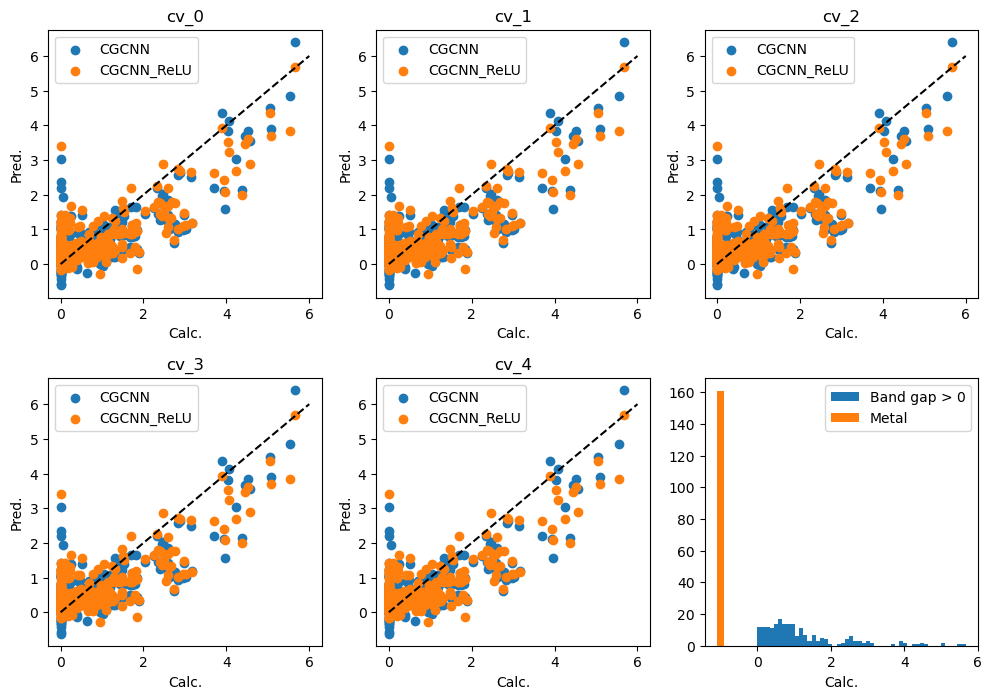

In [202]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

output = {
    'orig':[],
    'relu':[],
}
for i in range(5):
    with open(f'../output/matproj/bandgap/CGCNN/cv_{i:02d}/best.test.pkl','rb') as f:
        output['orig'].append(pickle.load(f))
    with open(f'../output/matproj/bandgap/CGCNN_relu/cv_{i:02d}/best.test.pkl','rb') as f:
        output['relu'].append(pickle.load(f))

f, axs = plt.subplots(2, 3, figsize=(12,8))
axs = axs.reshape(-1)
for i in range(5):
    axs[i].set_title(f'cv_{i}')
    axs[i].scatter(test_label, output['orig'][0], label='CGCNN')
    axs[i].scatter(test_label, output['relu'][0], label='CGCNN_ReLU')
for ax in axs[:-1]:
    ax.set_ylabel('Pred.')
    ax.set_xlabel('Calc.')
    ax.legend(loc='upper left')
    ax.plot([0,6],[0,6],color='k', ls='--')
f.subplots_adjust(hspace=0.3)
ax = axs[-1]
ax.hist(test_label[test_label > 0], bins=50, label='Band gap > 0')
ax.bar(-1, np.sum(test_label == 0), width=0.2, color=mpl.cm.tab10(1), label='Metal')
ax.set_xlabel('Calc.')
ax.legend(loc='upper right')

## Metal 분류 모델 훈련

- dataset 준비

In [7]:
from monty.serialization import loadfn

device = 'cuda'

mp_prop_data = loadfn('../data/mp_Li_O_3ele_clean.monty')
index = np.arange(len(mp_prop_data))
train_index, test_index = train_test_split(index, test_size = 0.2, random_state=123)

train_data = np.array(mp_prop_data)[sorted(train_index)]
test_data = np.array(mp_prop_data)[sorted(test_index)]

train_dataset = TorchDataset(train_data, target='is_metal', task='classification', r=3).to(device)
test_dataset = TorchDataset(test_data, target='is_metal', task='classification', r=3).to(device)

train_label = torch.concat([d.y for d in train_dataset], dim=0).cpu().numpy()
test_label = torch.concat([d.y for d in test_dataset], dim=0).cpu().numpy()

scaler = StandardGraphScaler(['x','edge_attr'])
scaled_train_dataset = scaler.fit_transform(train_dataset)
scaled_test_dataset = scaler.transform(test_dataset)

- data 분포

In [47]:
print('type  | metal | non-metal')
print('-'*25)
print('train | {:5d} | {:9d}'.format(train_label.sum(), (~train_label.astype(bool)).sum()))
print('test  | {:5d} | {:9d}'.format(test_label.sum(), (~test_label.astype(bool)).sum()))

type  | metal | non-metal
-------------------------
train |   628 |       846
test  |   162 |       207


- Cross entropy loss를 사용하려면 target의 dimension이 1차원 이어야 하기 때문에 collate_fn을 한번 더 정의

In [205]:
def class_collate_fn(dataset):
    feat, target = my_collate_fn(dataset)
    return feat, target.view(-1)

In [206]:
epochs = 500

test_dl = pdat.DataLoader(scaled_test_dataset, batch_size=256, collate_fn=class_collate_fn)
CV = CrossValidation(train_dataset, cv=5, return_index=True, seed=123)

for i in range(5):
    train_idx, valid_idx = CV[i]
    train_dl = pdat.DataLoader(scaled_train_dataset, batch_size=32, 
                               sampler=SubsetRandomSampler(train_idx), collate_fn=class_collate_fn)
    valid_dl = pdat.DataLoader(scaled_train_dataset, batch_size=256, 
                               sampler=valid_idx, collate_fn=class_collate_fn)
    
    model = CGCNN(
        num_node_features = test_dataset[0].num_node_features,
        num_edge_features = test_dataset[0].num_edge_features,
        num_atom_features = 32,
        num_hidden_features = 16,
        num_output_dim = 2,
        activation=torch.nn.LeakyReLU(0.05)
    ).to(device)
    
    crit = pnn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    tr = Trainer(model, opt, crit)
    
    output_path = f'../output/matproj/is_metal/cv_{i:02d}'
    os.makedirs(output_path, exist_ok=True)
    
    writer = SummaryWriter(output_path)
    best_loss = 1e5
    
    for epoch in range(1, epochs+1):
        train_loss = tr.train(train_dl)
        valid_loss, valid_result = tr.eval(valid_dl)
        test_loss, test_result = tr.eval(test_dl)
        
        valid_pred = valid_result.numpy().argmax(1)
        test_pred = test_result.numpy().argmax(1)
        
        valid_acc = accuracy_score(train_label[valid_idx], valid_pred)
        valid_f1 = f1_score(train_label[valid_idx], valid_pred)
        valid_rec = recall_score(train_label[valid_idx], valid_pred)
        valid_pre = precision_score(train_label[valid_idx], valid_pred)

        test_acc = accuracy_score(test_label, test_pred)
        test_f1 = f1_score(test_label, test_pred)
        test_rec = recall_score(test_label, test_pred)
        test_pre = precision_score(test_label, test_pred)
        
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Valid', valid_loss, epoch)
        writer.add_scalar('Loss/Test', test_loss, epoch)   
        writer.add_scalar('Accuracy/Valid', valid_acc, epoch)   
        writer.add_scalar('Accuracy/Test', test_acc, epoch)   
        writer.add_scalar('F1/Valid', valid_f1, epoch)   
        writer.add_scalar('F1/Test', test_f1, epoch)   
        writer.add_scalar('Recall/Valid', valid_rec, epoch)   
        writer.add_scalar('Recall/Test', test_rec, epoch)   
        writer.add_scalar('Precision/Valid', valid_pre, epoch)   
        writer.add_scalar('Precision/Test', test_pre, epoch)   
        
        if epoch % 100 == 0:
            save_output(output_path, f'{epoch:04d}.valid.pkl', valid_pred)
            save_output(output_path, f'{epoch:04d}.test.pkl', test_pred)
        if valid_loss < best_loss:
            best_loss = valid_loss
            save_output(output_path, f'best.valid.pkl', valid_pred)
            save_output(output_path, f'best.test.pkl', test_pred)
            with open(os.path.join(output_path, 'log.txt'),'w') as f:
                f.write('Epoch: {:4d} / Train loss: {:10.5f}\n'.format(epoch, train_loss))
                f.write('Valid Loss / ACC / F1 / Rec / Pre : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}\n'.format(
                    valid_loss, valid_acc, valid_f1, valid_rec, valid_pre))
                f.write('Test Loss / ACC / F1 / Rec / Pre  : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}\n'.format(
                    test_loss, test_acc, test_f1, test_rec, test_pre))

Text(0.5, 1.0, 'ensemble_tol: 0.300')

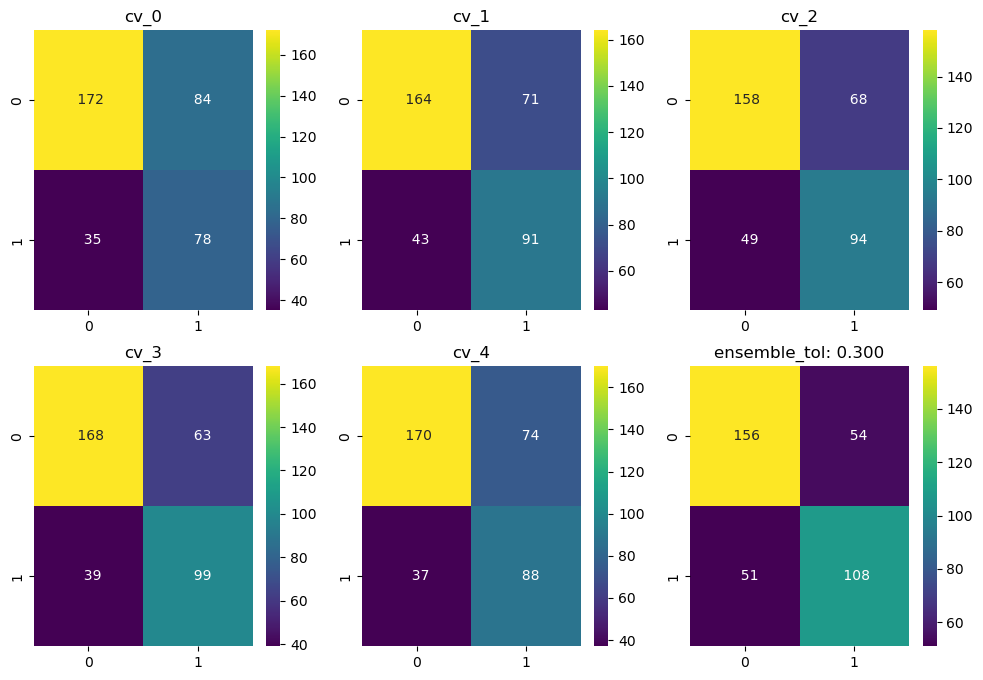

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix

output = []
for i in range(5):
    with open(f'../output/matproj/is_metal/cv_{i:02d}/best.test.pkl','rb') as f:
        output.append(pickle.load(f))

f, axs = plt.subplots(2,3,figsize=(12,8))
axs = axs.reshape(-1)
for i in range(5):
    cm = confusion_matrix(output[i], test_label.reshape(-1))
    sns.heatmap(cm, ax=axs[i], annot=True, fmt='4d',cmap='viridis')
    axs[i].set_title(f'cv_{i}')

tol = 0.3
cm = confusion_matrix((np.mean(output, axis=0) > tol).astype(int), test_label.reshape(-1))
sns.heatmap(cm, ax = axs[-1], annot=True, fmt='4d', cmap='viridis')
axs[-1].set_title(f'ensemble_tol: {tol:.3f}')

## Machine learning potential (MLP) 학습

참고: [MLFF bench github](https://github.com/SAITPublic/MLFF-Framework/tree/main?tab=readme-ov-file)

NNP, NLP, MLFF, ... 다양한 이름으로 불리며, 시스템의 total energy를 정확히 계산하는 것이 목표

force를 같이 학습시킬 경우 정확도가 올라간다는 연구 결과가 많음 (2018년~)

직접 만들기보단 MACE, E3NN, CHGNet, M3GNet 등 최신 모델을 활용할 것을 추천

DFT 계산 결과로 모델을 학습시키고 LAMMPS에 연결하여 활용 (Python으로 직접 MD 코드를 만들어서 돌려도 됨.)

In [61]:
from pymatgen.core import Structure

class MyFFData(MyData):
    def __init__(self, x, edge_index=[[], []], edge_attr=None, y=None, id=None, force=None):
        super(MyFFData, self).__init__(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, id=id)
        self._force = force
        if force is not None:
            self._force = force.float() if isinstance(force, torch.Tensor) else torch.tensor(force).float()

    @property
    def force(self):
        return self._force

    @force.setter
    def force(self, value):
        if self._force.shape != value.shape:
            raise ValueError('Invalid setting data', self._force.shape, value.shape)
        self._force = value

    def to(self, device):
        super().to(device)
        self._force = self._force.to(device)

class TorchFFDataset(pdat.Dataset):
    def __init__(self, mp_traj_dataset, target='e_fr_energy', unit_energy=False, r=3):
        super(TorchFFDataset, self).__init__()
        self._data = []
        for mp_traj_data in mp_traj_dataset:
            task_id = mp_traj_data['task_id']
            for i, trajs in enumerate(mp_traj_data['trajectories']):
                lattice = trajs['lattice']
                species = trajs['species']
                coords = trajs['coords']
                n_atom = len(species)
                for j, (coo, frame) in enumerate(zip(coords, trajs['frame_properties'])):
                    stru = Structure(lattice=lattice, species=species, coords=coo)
                    graph = strucutre_to_graph(stru, r=r)
                    force = frame['forces']
                    energy = frame[target]
                    if unit_energy: 
                        energy = energy / n_atom
                    n_edge = graph['edge_index'].shape[1]
                    self._data.append(MyFFData(
                        x = graph['x'],
                        edge_index = graph['edge_index'],
                        edge_attr = graph['edge_attr'].reshape(n_edge, -1),
                        y = energy,
                        id = f'{task_id}_{i}_{j}',
                        force = force,
                    ))
    
    def __getitem__(self, i):
        try:
            return [self._data[_i] for _i in i]
        except:                
            return self._data[i]

    def __len__(self):
        return len(self._data)

    def to(self, device):
        for d in self._data:
            d.to(device)
        return self

def ff_collate_fn(dataset):
    x = []
    edge_attr = []
    edge_index = []
    force = []
    y = []
    batch = []
    ptr = [0]
    id = []
    n = 0
    for i, data in enumerate(dataset):
        x.append(data.x)
        if data.y is not None: 
            y.append(data.y)
        if data.edge_attr is not None: 
            edge_attr.append(data.edge_attr)
        if data.force is not None: 
            force.append(data.force)
        
        edge_index.append(data.edge_index + n)
        batch.append(data.batch +i)
        n += data.num_nodes
        ptr.append(n)
        id.append(data.id)
        
    collated_data = MyFFData(
        x = torch.concat(x, dim=0),
        edge_attr = torch.concat(edge_attr, dim=0) if len(edge_attr) != 0 else None,
        edge_index = torch.concat(edge_index, dim=1),
        y = torch.concat(y, dim=0) if len(y) != 0 else None,
        force = torch.concat(force, dim=0) if len(y) != 0 else None,
        id = id
    )
    collated_data._batch = torch.concat(batch, dim=0)
    collated_data._ptr = torch.tensor(ptr).long()
    return collated_data, collated_data.force, collated_data.y

In [64]:
class CGCNNFF(pnn.Module):
    def __init__(self, 
                 num_node_features, 
                 num_edge_features,
                 num_atom_features=64, num_hidden_features=128,
                 num_convolution=3, num_hidden_layers=1,
                 activation=torch.nn.Softplus(),
                 pooling='add',
                 ):
        # num_node_features : orig_atom_fea_len
        # num_edge_features : nbr_fea_len
        # num_atom_feature : atom_fea_len
        # num_hidden_features : h_fea_len
        # num_convolution : n_conv
        # num_hidden_layers : n_h
        super(CGCNNFF, self).__init__()
        
        self.embedding = pnn.Linear(num_node_features, num_atom_features)
        
        conv_layers = []
        for _ in range(num_convolution):
            conv_layers.append(
                (
                    gnn.CGConv(channels=num_atom_features,
                               dim=num_edge_features,
                               batch_norm=True),
                    'x, edge_index, edge_attr -> x'
                )
            )
        self.conv_layers = gnn.Sequential(
            'x, edge_index, edge_attr', conv_layers
        )

        # energy / atom 이라면 mean pool, total energy라면 add pool
        self.pooling = eval(f'gnn.global_{pooling}_pool')
        # force 정보를 학습하기 위해선 pooling 전의 정보가 필요하기 때문에 분리함
        
        # force output layer
        force_output_layers = [
            activation,
            pnn.Linear(num_atom_features, num_hidden_features),
            activation,
        ]
        for _ in range(max(num_hidden_layers - 1, 0)):
            force_output_layers.append(pnn.Linear(num_hidden_features, num_hidden_features))
            force_output_layers.append(activation)
        force_output_layers.append(pnn.Linear(num_hidden_features, 3))
        
        self.force_output_layers = pnn.Sequential(*force_output_layers)
        
        # energy output layer
        energy_output_layers = [
            activation,
            pnn.Linear(num_atom_features, num_hidden_features),
            activation,
        ]
        for _ in range(max(num_hidden_layers - 1, 0)):
            energy_output_layers.append(pnn.Linear(num_hidden_features, num_hidden_features))
            energy_output_layers.append(activation)
        energy_output_layers.append(pnn.Linear(num_hidden_features, 1))
        
        self.energy_output_layers = pnn.Sequential(*energy_output_layers)

    def forward(self, data):
        h_embed = self.embedding(data.x)
        h_conv = self.conv_layers(x = h_embed,
                                  edge_attr=data.edge_attr, 
                                  edge_index = data.edge_index,
        )
        force  = self.force_output_layers(h_conv)
        energy = self.energy_output_layers(self.pooling(h_conv, data.batch))
        return force, energy

class FFTrainer(Trainer):
    def __init__(self, model, opt, crit, alpha=0.001):
        super(FFTrainer, self).__init__(model, opt, crit)
        self._alpha = alpha
    
    def train(self, dataloader):
        self._model.train()
        train_loss = 0
        for feat, force, energy in dataloader:
            pred1, pred2 = self._model(feat) # 예측
            
            loss1 = self._crit(pred1, force) # force loss 계산
            loss2 = self._crit(pred2, energy) # energy loss 계산
            loss = loss1 + self._alpha * loss2
            
            self._opt.zero_grad() # gradient 초기화
            loss.backward() # loss 역전파
            self._opt.step()
            
            train_loss += loss.detach().item()
        return train_loss / len(dataloader)
    
    def eval(self, dataloader):
        self._model.eval()
        eval_loss = 0
        eval_output1 = []
        eval_output2 = []
        with torch.no_grad():
            for feat, force, energy in dataloader:
                pred1, pred2 = self._model(feat) # 예측
                
                loss1 = self._crit(pred1, force) # force loss 계산
                loss2 = self._crit(pred2, energy) # energy loss 계산
                loss = loss1 + self._alpha * loss2

                eval_loss += loss.detach().item()
                eval_output1.append(pred1)
                eval_output2.append(pred2)
        return eval_loss / len(dataloader), torch.concat(eval_output1, dim=0).cpu(), torch.concat(eval_output2, dim=0).cpu()

- total energy 훈련

In [65]:
mp_traj_data = json.load(open('../data/mp_traj_LiSiO.json'))
traj_train_data, traj_test_data = mp_traj_data[:-2], mp_traj_data[-2:]

device = 'cuda'
train_dataset = TorchFFDataset(traj_train_data, target='e_fr_energy', r=3).to(device)
test_dataset = TorchFFDataset(traj_test_data, target='e_fr_energy', r=3).to(device)

train_force = np.array([d.force.cpu().numpy() for d in train_dataset], dtype=object)
train_energy = torch.concat([d.y for d in train_dataset], dim=0).cpu().numpy()
test_force = torch.concat([d.force for d in test_dataset], dim=0).cpu().numpy()
test_energy = torch.concat([d.y for d in test_dataset], dim=0).cpu().numpy()

scaler = StandardGraphScaler(['x','edge_attr','y'])
scaled_train_dataset = scaler.fit_transform(train_dataset)
scaled_test_dataset = scaler.transform(test_dataset)

print('Train frames : ', len(train_dataset))
print('Test frames  : ', len(test_dataset))

Train frames :  380
Test frames  :  111


In [66]:
epochs = 1500

test_dl = pdat.DataLoader(scaled_test_dataset, batch_size=256, collate_fn=ff_collate_fn)
CV = CrossValidation(train_dataset, cv=3, return_index=True, seed=123)

for i in range(3):
    train_idx, valid_idx = CV[i]
    train_dl = pdat.DataLoader(scaled_train_dataset, batch_size=32, 
                               sampler=SubsetRandomSampler(train_idx), collate_fn=ff_collate_fn)
    valid_dl = pdat.DataLoader(scaled_train_dataset, batch_size=256, 
                               sampler=valid_idx, collate_fn=ff_collate_fn)
    
    model = CGCNNFF(
        num_node_features = test_dataset[0].num_node_features,
        num_edge_features = test_dataset[0].num_edge_features,
        pooling = 'add', ### total energy 이므로 add pooling
    ).to(device)
    
    crit = pnn.MSELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    tr = FFTrainer(model, opt, crit, alpha=0.01)
    
    output_path = f'../output/matproj/ff/e_total/cv_{i:02d}'
    os.makedirs(output_path, exist_ok=True)
    
    writer = SummaryWriter(output_path)
    best_loss = 1e5
    
    for epoch in range(1, epochs+1):
        train_loss = tr.train(train_dl)
        valid_loss, valid_force_pred, valid_energy_pred = tr.eval(valid_dl)
        test_loss, test_force_pred, test_energy_pred = tr.eval(test_dl)
        
        valid_energy_pred = scaler.inverse_transform_vector(valid_energy_pred.to(device), 'y').to('cpu').numpy()
        test_energy_pred = scaler.inverse_transform_vector(test_energy_pred.to(device), 'y').to('cpu').numpy()
        
        valid_force_mae = mean_absolute_error(np.vstack(train_force[valid_idx]), valid_force_pred)
        valid_energy_r2 = r2_score(train_energy[valid_idx], valid_energy_pred)
        valid_energy_mae = mean_absolute_error(train_energy[valid_idx], valid_energy_pred)

        test_force_mae = mean_absolute_error(test_force, test_force_pred)
        test_energy_r2 = r2_score(test_energy, test_energy_pred)
        test_energy_mae = mean_absolute_error(test_energy, test_energy_pred)
        
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Valid', valid_loss, epoch)
        writer.add_scalar('Loss/Test', test_loss, epoch)   
        writer.add_scalar('R2_energy/Valid', valid_energy_r2, epoch)   
        writer.add_scalar('R2_energy/Test', test_energy_r2, epoch)   
        writer.add_scalar('MAE_energy/Valid', valid_energy_mae, epoch)   
        writer.add_scalar('MAE_energy/Test', test_energy_mae, epoch)
        writer.add_scalar('MAE_force/Valid', valid_force_mae, epoch)   
        writer.add_scalar('MAE_force/Test', test_force_mae, epoch)
        
        if epoch % 500 == 0:
            save_output(output_path, f'{epoch:04d}.valid.pkl', [valid_force_pred, valid_energy_pred])
            save_output(output_path, f'{epoch:04d}.test.pkl', [test_force_pred, test_energy_pred])
        if valid_loss < best_loss:
            best_loss = valid_loss
            save_output(output_path, f'best.valid.pkl', [valid_force_pred, valid_energy_pred])
            save_output(output_path, f'best.test.pkl', [test_force_pred, test_energy_pred])
            with open(os.path.join(output_path, 'log.txt'),'w') as f:
                f.write('Epoch: {:4d} / Train loss: {:10.5f}\n'.format(epoch, train_loss))
                f.write('Valid Loss / EnergyR2 / EnergyMAE / ForceMAE: {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}\n'.format(
                    valid_loss, valid_energy_r2, valid_energy_mae, valid_force_mae))
                f.write('Test Loss / EnergyR2 / EnergyMAE / ForceMAE : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}\n'.format(
                    test_loss, test_energy_r2, test_energy_mae, test_force_mae))

- energy per atom 훈련

In [67]:
mp_traj_data = json.load(open('../data/mp_traj_LiSiO.json'))
traj_train_data, traj_test_data = mp_traj_data[:-2], mp_traj_data[-2:]

device = 'cuda'
# unit_energy = True 로 바꿔서 energy per atom 을 target값으로
train_dataset = TorchFFDataset(traj_train_data, target='e_fr_energy', unit_energy=True, r=3).to(device)
test_dataset = TorchFFDataset(traj_test_data, target='e_fr_energy', unit_energy=True, r=3).to(device)

train_force = np.array([d.force.cpu().numpy() for d in train_dataset], dtype=object)
train_energy = torch.concat([d.y for d in train_dataset], dim=0).cpu().numpy()
test_force = torch.concat([d.force for d in test_dataset], dim=0).cpu().numpy()
test_energy = torch.concat([d.y for d in test_dataset], dim=0).cpu().numpy()

scaler = StandardGraphScaler(['x','edge_attr','y'])
scaled_train_dataset = scaler.fit_transform(train_dataset)
scaled_test_dataset = scaler.transform(test_dataset)

In [70]:
epochs = 1500

test_dl = pdat.DataLoader(scaled_test_dataset, batch_size=256, collate_fn=ff_collate_fn)
CV = CrossValidation(train_dataset, cv=3, return_index=True, seed=123)

for i in range(3):
    train_idx, valid_idx = CV[i]
    train_dl = pdat.DataLoader(scaled_train_dataset, batch_size=32, 
                               sampler=SubsetRandomSampler(train_idx), collate_fn=ff_collate_fn)
    valid_dl = pdat.DataLoader(scaled_train_dataset, batch_size=256, 
                               sampler=valid_idx, collate_fn=ff_collate_fn)
    
    model = CGCNNFF(
        num_node_features = test_dataset[0].num_node_features,
        num_edge_features = test_dataset[0].num_edge_features,
        pooling = 'mean' #### unit energy 이므로 mean pooling
    ).to(device)
    
    crit = pnn.MSELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    tr = FFTrainer(model, opt, crit, alpha=0.01)
    
    output_path = f'../output/matproj/ff/e_unit/cv_{i:02d}'
    os.makedirs(output_path, exist_ok=True)
    
    writer = SummaryWriter(output_path)
    best_loss = 1e5
    
    for epoch in range(1, epochs+1):
        train_loss = tr.train(train_dl)
        valid_loss, valid_force_pred, valid_energy_pred = tr.eval(valid_dl)
        test_loss, test_force_pred, test_energy_pred = tr.eval(test_dl)
        
        valid_energy_pred = scaler.inverse_transform_vector(valid_energy_pred.to(device), 'y').to('cpu').numpy()
        test_energy_pred = scaler.inverse_transform_vector(test_energy_pred.to(device), 'y').to('cpu').numpy()
        
        valid_force_mae = mean_absolute_error(np.vstack(train_force[valid_idx]), valid_force_pred)
        valid_energy_r2 = r2_score(train_energy[valid_idx], valid_energy_pred)
        valid_energy_mae = mean_absolute_error(train_energy[valid_idx], valid_energy_pred)

        test_force_mae = mean_absolute_error(test_force, test_force_pred)
        test_energy_r2 = r2_score(test_energy, test_energy_pred)
        test_energy_mae = mean_absolute_error(test_energy, test_energy_pred)
        
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Valid', valid_loss, epoch)
        writer.add_scalar('Loss/Test', test_loss, epoch)   
        writer.add_scalar('R2_energy/Valid', valid_energy_r2, epoch)   
        writer.add_scalar('R2_energy/Test', test_energy_r2, epoch)   
        writer.add_scalar('MAE_energy/Valid', valid_energy_mae, epoch)   
        writer.add_scalar('MAE_energy/Test', test_energy_mae, epoch)
        writer.add_scalar('MAE_force/Valid', valid_force_mae, epoch)   
        writer.add_scalar('MAE_force/Test', test_force_mae, epoch)
        
        if epoch % 500 == 0:
            save_output(output_path, f'{epoch:04d}.valid.pkl', [valid_force_pred, valid_energy_pred])
            save_output(output_path, f'{epoch:04d}.test.pkl', [test_force_pred, test_energy_pred])
        if valid_loss < best_loss:
            best_loss = valid_loss
            save_output(output_path, f'best.valid.pkl', [valid_force_pred, valid_energy_pred])
            save_output(output_path, f'best.test.pkl', [test_force_pred, test_energy_pred])
            with open(os.path.join(output_path, 'log.txt'),'w') as f:
                f.write('Epoch: {:4d} / Train loss: {:10.5f}\n'.format(epoch, train_loss))
                f.write('Valid Loss / EnergyR2 / EnergyMAE / ForceMAE: {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}\n'.format(
                    valid_loss, valid_energy_r2, valid_energy_mae, valid_force_mae))
                f.write('Test Loss / EnergyR2 / EnergyMAE / ForceMAE : {:10.5f} / {:10.5f} / {:10.5f} / {:10.5f}\n'.format(
                    test_loss, test_energy_r2, test_energy_mae, test_force_mae))